In [34]:
import pandas as pd
import numpy as np
import scipy
from scipy import sparse
import lightfm
print(pd.__version__)
print(scipy.__version__)
print(lightfm.__version__)

path = '../data/'

0.20.1
0.19.0
1.13


In [35]:
swipes = pd.read_csv(path + 'surgeapp_swipes.raw.csv')
swipes.head(10)

,from_account_id,to_account_id,created,liked,superlike,recycled
0,239191,2243372,2016-05-12 03:58:10.996672,t,f,NaN
1,2602100,2243372,2016-08-25 01:43:25.775144,t,f,NaN
2,2082098,2243372,2016-06-10 13:37:36.451993,f,f,NaN
3,294483,2243372,2016-07-26 07:12:55.34634,t,f,NaN
4,124990,2243372,2016-05-17 02:34:13.533005,f,f,NaN
5,3228297,2243372,2017-03-20 07:13:23.112937,f,f,NaN
6,2465892,2243372,2016-07-16 19:35:41.974981,t,f,NaN
7,2171011,2243372,2017-03-31 11:36:59.853332,t,f,NaN
8,2575257,2243372,2016-08-19 20:06:58.231034,t,f,NaN
9,493269,2243372,2016-06-01 18:04:59.297187,t,f,NaN


In [36]:
# We need to re-index, the COO-matrix can't use the raw account_ids because it creates NxM based on the maximum value
# for each dimension.
accounts = pd.read_csv(path + 'surgeapp_accounts.csv')
accounts.reset_index(inplace=True)
accounts.head(10)

,index,id,email,fb_id,locale,device,email_provider,has_fb_id,lang,country
0,0,54362,chappyboy01@gmail.com,1.000018e+14,en_US,unknown,gmail,False,en,US
1,1,73244,Decemeth@gmail.com,NaN,en_US,unknown,gmail,True,en,US
2,2,76839,kenyatta251979@yahoo.com,1.000052e+14,en_US,unknown,yahoo,False,en,US
3,3,92132,chaltom@mac.com,1.015264e+16,en_US,unknown,other,False,en,US
4,4,92220,losifranco@gmail.com,NaN,en_US,unknown,gmail,True,en,US
5,5,93194,coloursofsymphony@yahoo.com,NaN,en_US,unknown,yahoo,True,en,US
6,6,93760,wctopel@gmail.com,1.020730e+16,en_US,unknown,gmail,False,en,US
7,7,94416,gamnyc@me.com,NaN,en_US,unknown,other,True,en,US
8,8,95093,vincent112345@hotmail.com,1.015297e+16,en_US,unknown,hotmail,False,en,US
9,9,96987,ameerkhan4277@gmail.com,7.072415e+14,en_US,unknown,gmail,False,en,US


In [37]:
lookup = accounts[['index', 'id']]
swipes = pd.merge(swipes, lookup, left_on='from_account_id', right_on='id') \
    .rename(columns={'index':'from_id'})
swipes = pd.merge(swipes, lookup, left_on='to_account_id', right_on='id') \
    .rename(columns={'index':'to_id'})
swipes = swipes[['from_id', 'from_account_id', 'to_id', 'to_account_id', 'liked', 'superlike']]
swipes.head(10)

,from_id,from_account_id,to_id,to_account_id,liked,superlike
0,266,239191,1485,2243372,t,f
1,2130,2602100,1485,2243372,t,f
2,1305,2082098,1485,2243372,f,f
3,354,294483,1485,2243372,t,f
4,59,124990,1485,2243372,f,f
5,5471,3228297,1485,2243372,f,f
6,1856,2465892,1485,2243372,t,f
7,1395,2171011,1485,2243372,t,f
8,2063,2575257,1485,2243372,t,f
9,635,493269,1485,2243372,t,f


In [38]:
print(swipes.shape)
print(swipes[swipes.superlike == 't'].shape)
print(swipes[swipes.liked == 't'].shape)

(5739794, 6)
(7006, 6)
(1241553, 6)


In [39]:
# Let's examine the dataset and see if the recycle creates a duplicate record, if so, we'll take the most recent
gb = swipes[['from_id', 'to_id', 'liked']].groupby(['from_id', 'to_id']).count() \
    .reset_index().rename(columns={'liked': 'c'})
gb[gb.c > 1].shape[0]

0

In [40]:
swipes[(swipes.liked == 't') & (swipes.superlike == 't')].head()

,from_id,from_account_id,to_id,to_account_id,liked,superlike
128,1187,1071004,1485,2243372,t,t
154,1613,2337129,1485,2243372,t,t
506,42,117554,1485,2243372,t,t
547,1869,2475581,1485,2243372,t,t
553,525,417635,1485,2243372,t,t


In [41]:
# Ok, so let's assign inferred scores based on how the swipe went. If the swipe was a like, we'll call that 1 point. If
# the swipe was a super like, that should be considerably more (maybe 5?). However, 
# If the swipe was recycled that means it could either be a correction of a mistake, or a "ehhh I'll take another look"
# We can't really identify the two easily, so perhaps we'll just ignore recycled for now.
# If the swipe was a pass, that's a negative signal so we'll set that score to -1
swipes['score'] = 0
swipes.loc[swipes.liked == 't', 'score'] = 1

In [42]:
print(swipes.head(10))
print(len(swipes.from_id.unique()))
print(len(swipes.to_id.unique()))

   from_id  from_account_id  to_id  to_account_id liked superlike  score
0      266           239191   1485        2243372     t         f      1
1     2130          2602100   1485        2243372     t         f      1
2     1305          2082098   1485        2243372     f         f      0
3      354           294483   1485        2243372     t         f      1
4       59           124990   1485        2243372     f         f      0
5     5471          3228297   1485        2243372     f         f      0
6     1856          2465892   1485        2243372     t         f      1
7     1395          2171011   1485        2243372     t         f      1
8     2063          2575257   1485        2243372     t         f      1
9      635           493269   1485        2243372     t         f      1
5677
5896


In [43]:
swipes_mtx = sparse.coo_matrix((swipes.score, (swipes.from_id, swipes.to_id)))
swipes_mtx

<6550x6550 sparse matrix of type '<class 'numpy.int64'>'
	with 5739794 stored elements in COOrdinate format>

In [44]:
from scipy.sparse import coo_matrix
import random

train_row = []
train_col = []
train_dat = []
test_row = []
test_col = []
test_dat = []
for i,j,v in zip(swipes_mtx.row, swipes_mtx.col, swipes_mtx.data):
    if np.random.random() < .8:
        train_row.append(i)
        train_col.append(j)
        train_dat.append(v)
    else:
        test_row.append(i)
        test_col.append(j)
        test_dat.append(v)

In [45]:
print(np.asarray(train_row).max())
print(np.asarray(train_col).max())
train_mtx = coo_matrix((train_dat, (train_row, train_col)))
test_mtx = coo_matrix((test_dat, (test_row, test_col)))

6549
6549


In [46]:
train_mtx

<6550x6550 sparse matrix of type '<class 'numpy.int64'>'
	with 4592439 stored elements in COOrdinate format>

In [47]:
test_mtx

<6550x6550 sparse matrix of type '<class 'numpy.int64'>'
	with 1147355 stored elements in COOrdinate format>

In [133]:
# Let's start with a grid search to try to find the best params for learning
def objective(params):
    # unpack
    epochs, learning_sched, learning_rate, no_components, max_sampled = params
    print(params)
    
    model = LightFM(loss='warp'
                    ,random_state=2017
                    ,learning_schedule='adagrad' if learning_sched < .5 else 'adadelta'
                    ,learning_rate=learning_rate
                    ,no_components=no_components
                    ,max_sampled=max_sampled)
    
    model.fit(train_mtx, epochs=epochs, num_threads=8, verbose=False)
    
    patks = lightfm.evaluation.precision_at_k(model, test_mtx, train_interactions=train_mtx, k=5, num_threads=8)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Weird shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

space = [(5, 100),     # epochs
         (0, 1),       # learning_rate_schedule
         (0.005, 0.1), # initial learning rate for adagrad
         (5, 100),     # no_components
         (5, 25)       # max_sampled
        ]

from skopt import forest_minimize
res_fm = forest_minimize(objective
                         ,space
                         ,n_calls=100
#                          ,random_state=2017
                         ,verbose=True
                         )

Iteration No: 1 started. Evaluating function at random point.
[63, 0, 0.06982508386182007, 85, 13]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 76.3953
Function value obtained: -0.4580
Current minimum: -0.4580
Iteration No: 2 started. Evaluating function at random point.
[32, 1, 0.048616327952423294, 32, 21]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 41.1103
Function value obtained: -0.4746
Current minimum: -0.4746
Iteration No: 3 started. Evaluating function at random point.
[37, 0, 0.082947764560705739, 36, 12]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 37.9390
Function value obtained: -0.4691
Current minimum: -0.4746
Iteration No: 4 started. Evaluating function at random point.
[80, 1, 0.066012375916928961, 87, 9]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 90.3308
Function value obtained: -0.4467
Current minimum: -0.4746
Iteration No: 5 started. Evaluating function at random point.
[56,

Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 87.2082
Function value obtained: -0.4665
Current minimum: -0.4895
Iteration No: 36 started. Searching for the next optimal point.
[71, 0, 0.03301901284917224, 94, 12]
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 86.9960
Function value obtained: -0.4795
Current minimum: -0.4895
Iteration No: 37 started. Searching for the next optimal point.
[71, 0, 0.042990867152393114, 72, 24]
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 96.0623
Function value obtained: -0.4686
Current minimum: -0.4895
Iteration No: 38 started. Searching for the next optimal point.
[60, 0, 0.028500062564384344, 83, 16]
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 78.7178
Function value obtained: -0.4854
Current minimum: -0.4895
Iteration No: 39 started. Searching for the next optimal point.
[72, 0, 0.036082920459272604, 81, 13]
Iteration

Iteration No: 69 ended. Search finished for the next optimal point.
Time taken: 47.9253
Function value obtained: -0.4897
Current minimum: -0.4904
Iteration No: 70 started. Searching for the next optimal point.
[49, 0, 0.018149591894862566, 100, 15]
Iteration No: 70 ended. Search finished for the next optimal point.
Time taken: 80.1858
Function value obtained: -0.4880
Current minimum: -0.4904
Iteration No: 71 started. Searching for the next optimal point.
[24, 0, 0.02248824101858787, 100, 14]
Iteration No: 71 ended. Search finished for the next optimal point.
Time taken: 39.9152
Function value obtained: -0.4831
Current minimum: -0.4904
Iteration No: 72 started. Searching for the next optimal point.
[25, 0, 0.015264070998181552, 98, 11]
Iteration No: 72 ended. Search finished for the next optimal point.
Time taken: 39.5832
Function value obtained: -0.4669
Current minimum: -0.4904
Iteration No: 73 started. Searching for the next optimal point.
[42, 0, 0.013836425468263865, 96, 19]
Iterati

In [134]:
# Print the best configuration
print('Maximimum p@k found: {:6.5f}'.format(-res_fm.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_schedule', 'learning_rate', 'no_components', 'max_sampled']
# Learning Schedule = 'adagrad' if learning_sched < .5 else 'adadelta'
for (p, x_) in zip(params, res_fm.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.49095
Optimal parameters:
epochs: 35
learning_schedule: 0
learning_rate: 0.023924696693413378
no_components: 98
max_sampled: 25


In [135]:
# Build a dataframe out of all of the results
cols = ['value', 'e', 'sched', 'rate', 'comps', 'samp']
itersdf = pd.DataFrame(columns=cols)
for val, x in zip(res_fm.func_vals, res_fm.x_iters):
    row = [-val]
    for (p, x_) in zip(params, x):
        row += [x_]
    itersdf = itersdf.append(pd.DataFrame([row], columns=cols), ignore_index=True)

itersdf = itersdf.sort_values('value', ascending=False)
itersdf.head(10)

,value,e,sched,rate,comps,samp
77,0.490952,35,0,0.023925,98,25
76,0.490736,38,0,0.025925,99,23
90,0.490592,35,0,0.025470,95,24
39,0.490448,81,0,0.024157,84,10
63,0.489872,51,0,0.026479,100,12
51,0.489836,43,0,0.025703,98,16
68,0.489728,31,0,0.026588,100,14
82,0.489692,79,0,0.017564,67,12
85,0.489692,43,0,0.019978,99,24
21,0.489548,68,0,0.020738,94,13


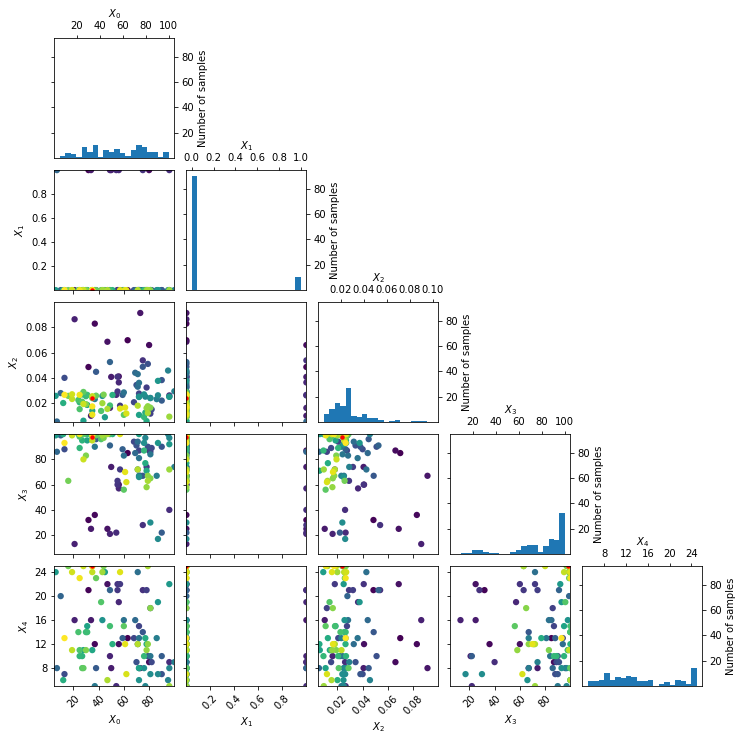

In [136]:
# Let's try some visualizations from skopt...
%matplotlib inline
import matplotlib.pyplot as plt
from skopt.plots import plot_evaluations, plot_objective
_ = plot_evaluations(res_fm)

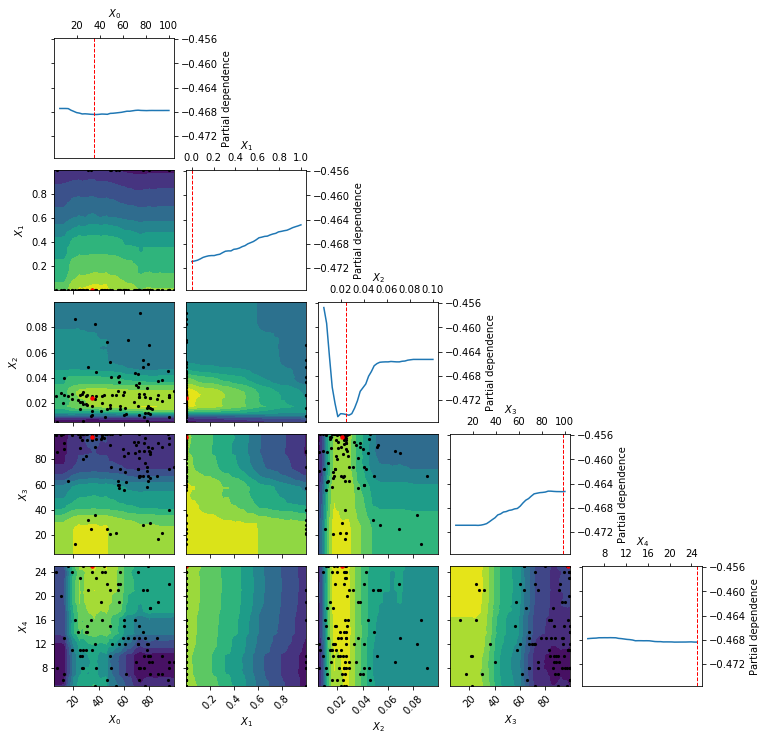

In [137]:
_ = plot_objective(res_fm)

# Learning Curves
Now that we've found some good parameters for the model, let's build learning curves to make sure we're not obvious
overfitting or underfitting...

In [122]:
# Let's construct some learning curves for AUC and P@k for the model
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

# Optimal parameters...
# epochs:77, learning_rate_schedule='adagrad', learning_rate='0.027001', no_components=89, max_sample=8

model = lightfm.LightFM(loss='warp'
                        ,learning_schedule='adagrad'
                        ,learning_rate=0.027
                        ,no_components=89
                        ,max_sampled=8
                        )

# Construct 
EPOCHS = 77
train_aucs = []
test_aucs = []
train_paks = []
test_paks = []

# Let's get an initial pass in to see where we're starting
model.fit_partial(train_mtx, epochs=1, num_threads=8)
train_aucs.append(auc_score(model, train_mtx, num_threads=8).mean())
test_aucs.append(auc_score(model, test_mtx, num_threads=8).mean())
train_paks.append(precision_at_k(model, train_mtx, k=20, num_threads=8).mean())
test_paks.append(precision_at_k(model, test_mtx, train_interactions=train_mtx, k=20, num_threads=8).mean())
print("Completed epoch: {}".format(1))

# Now train 5 epochs at a time until we reach the max
for i in range(int(EPOCHS/5)):
    model.fit_partial(train_mtx, epochs=5, num_threads=8)
    train_aucs.append(auc_score(model, train_mtx, num_threads=8).mean())
    test_aucs.append(auc_score(model, test_mtx, train_interactions=train_mtx, num_threads=8).mean())
    train_paks.append(precision_at_k(model, train_mtx, k=20, num_threads=8).mean())
    test_paks.append(precision_at_k(model, test_mtx, train_interactions=train_mtx, k=20, num_threads=8).mean())
    print("Completed epoch: {}".format(1+(i+1)*5))


Completed epoch: 1
Completed epoch: 6
Completed epoch: 11
Completed epoch: 16
Completed epoch: 21
Completed epoch: 26
Completed epoch: 31
Completed epoch: 36
Completed epoch: 41
Completed epoch: 46
Completed epoch: 51
Completed epoch: 56
Completed epoch: 61
Completed epoch: 66
Completed epoch: 71
Completed epoch: 76


ValueError: x and y must have same first dimension, but have shapes (16,) and (1,)

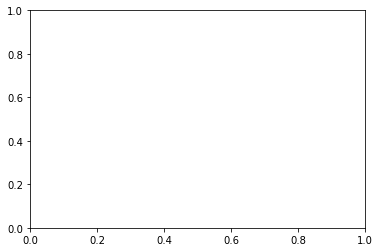

In [128]:
# AUC: Probability that a randomly chosen positive example will be ranked higher than a random negative example
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS+2, 5), train_aucs, 'b')
plt.plot(range(1, EPOCHS+2, 5), test_aucs, 'g')
plt.ylabel('AUC')
plt.xlabel('Epoch #')
plt.show()

In [124]:
# Let's look at the final numbers...
train_auc = auc_score(model, train_mtx, num_threads=8).mean()
test_auc = auc_score(model, test_mtx, train_interactions=train_mtx, num_threads=8).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.87, test 0.88.


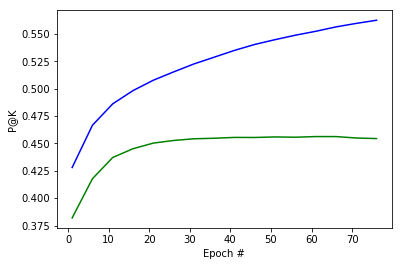

In [127]:
# Precision at k: What proportion of the top k results are positives
import matplotlib.pyplot as plt
plt.plot(range(1, EPOCHS+2, 5), train_paks, 'b')
plt.plot(range(1, EPOCHS+2, 5), test_paks, 'g')
plt.ylabel('P@K')
plt.xlabel('Epoch #')
plt.show()

In [129]:
# And a look at the exact numbers...
train_precision = precision_at_k(model, train_mtx, k=20, num_threads=8).mean()
test_precision = precision_at_k(model, test_mtx, train_interactions=train_mtx, k=20, num_threads=8).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.56, test 0.45.


In [130]:
# Let's print out the recommendations for any random 5 users - this is essentially a sanity check (specifically, we
# want to see that each user has different ID's)
for i in random.sample(range(1, 6550), 5):
    print("User idx: {} ---------------------------------------".format(i))
    predictions = model.predict(i, lookup['index'].values, num_threads=8)
    preds_df = pd.DataFrame({'useridx': lookup['index'].values, 'rankscore': predictions})
    print(preds_df.sort_values('rankscore', ascending=False).head())
    rankscore, rankeduser = np.unique(predictions[~np.isnan(predictions)], return_index=True)

User idx: 5464 ---------------------------------------
      rankscore  useridx
129    0.942543      129
1531   0.924070     1531
1485   0.915210     1485
2574   0.894847     2574
1423   0.887586     1423
User idx: 1794 ---------------------------------------
      rankscore  useridx
1446   2.459763     1446
2615   2.250999     2615
1767   2.162703     1767
1883   2.113961     1883
2223   2.023521     2223
User idx: 3782 ---------------------------------------
      rankscore  useridx
2135  -0.044303     2135
444   -0.162059      444
1004  -0.247332     1004
3382  -0.323759     3382
1883  -0.343317     1883
User idx: 2145 ---------------------------------------
      rankscore  useridx
5488   0.088137     5488
2662   0.027155     2662
5952  -0.020724     5952
5606  -0.108566     5606
5254  -0.191172     5254
User idx: 5369 ---------------------------------------
      rankscore  useridx
129    0.928024      129
1485   0.904205     1485
1531   0.896594     1531
2574   0.870344     2574


# Now for the hybrid recommendations...

In [140]:
profiles = pd.read_csv(path + 'surgeapp_profiles.csv')

In [141]:
users = pd.merge(accounts, profiles, left_on='id', right_on='account_id', how='left')
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6550 entries, 0 to 6549
Data columns (total 55 columns):
index                            6550 non-null int64
id                               6550 non-null int64
email                            6550 non-null object
fb_id                            2020 non-null float64
locale                           6550 non-null object
device                           6550 non-null object
email_provider                   6550 non-null object
has_fb_id                        6550 non-null bool
lang                             6550 non-null object
country                          6550 non-null object
account_id                       6550 non-null int64
seen                             6550 non-null object
birthday                         6550 non-null object
public_photos                    5056 non-null object
private_photos                   982 non-null object
weight                           3255 non-null float64
height                           

In [142]:
# users = users[['has_fb_id', 'weightkg', 'height', 'profile_length', 'couple', 'private_mode', \
#                'transgender', 'Role_Bottom', 'Role_Bottom_Versatile', 'Role_Top', 'Role_Top_Versatile', \
#                'Role_Unspecified', 'Role_Versatile', 'Relationship_Complicated', 'Relationship_InARelationship', \
#                'Relationship_OpenRelationship', 'Relationship_Single', 'hide_distance', 'hide_age', 'age', \
#                'public_photo_count', 'private_photo_count', 'lf_chat', 'lf_dates', 'lf_friends', 'lf_networking', \
#                'lf_relationships', 'lf_hookup', 'insta_photos_count']]
users = users[['age', 'weightkg', 'height', 'public_photo_count', 'insta_photos_count', 'lf_chat', 'lf_dates', \
               'lf_friends', 'lf_networking', 'lf_relationships', 'lf_hookup']]

# Impute the missing heights and weights with the mean
users.loc[pd.isnull(users.weightkg), 'weightkg'] = users.weightkg.mean()
users.loc[pd.isnull(users.height), 'height'] = users.height.mean()

# Normalize 0-1
users['age'] = users.age.map(lambda x: (x - users.age.min()) / (users.age.max() - users.age.min()))
users['weightkg'] = users.weightkg.map(lambda x: (x - users.weightkg.min()) / (users.weightkg.max() - users.weightkg.min()))
users['height'] = users.height.map(lambda x: (x - users.height.min()) / (users.height.max() - users.height.min()))
users['public_photo_count'] = users.public_photo_count.map( \
    lambda x: (x - users.public_photo_count.min()) / (users.public_photo_count.max() - users.public_photo_count.min()))
users['insta_photos_count'] = users.insta_photos_count.map( \
    lambda x: (x - users.insta_photos_count.min()) / (users.insta_photos_count.max() - users.insta_photos_count.min()))

import pandas_profiling
pandas_profiling.ProfileReport(users)

/Users/davenovelli/miniconda3/envs/strvworkshop/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Number of variables,11
Number of observations,6550
Total Missing (%),0.0%
Total size in memory,614.1 KiB
Average record size in memory,96.0 B
Numeric,11
Categorical,0
Date,0
Text (Unique),0
Rejected,0
Distinct count,61


In [144]:
from scipy.sparse import csr_matrix
users_csr = csr_matrix(users) #Don't include the index
users_csr

<6550x11 sparse matrix of type '<class 'numpy.float64'>'
	with 38770 stored elements in Compressed Sparse Row format>

In [152]:
# Grid search to make sure that we're picking the best params for learning - with default settings the hybrid
# model is doing considerably worse than the standard model
def objective(params):
    # unpack
    epochs, learning_rate, no_components, max_sampled, user_alpha = params
    print(params)
    
    model = LightFM(loss='warp'
                    ,random_state=2017
                    ,learning_rate=learning_rate
                    ,no_components=no_components
                    ,max_sampled=max_sampled
                    ,user_alpha=user_alpha)
    try:
        model.fit(train_mtx, epochs=epochs, user_features=users_csr, num_threads=8, verbose=False)
    except ValueError as err:
        print(err)
        return 0.0
    except Exception as err:
        print('Handling unexpected run-time error:', err)
        return 0.0
    
    patks = lightfm.evaluation.precision_at_k(model, test_mtx, user_features=users_csr
                                              ,train_interactions=train_mtx, k=20, num_threads=8)
    mapatk = np.mean(patks)
    # Make negative because we want to _minimize_ objective
    out = -mapatk
    # Weird shit going on
    if np.abs(out + 1) < 0.01 or out < -1.0:
        return 0.0
    else:
        return out

space = [(10, 30),     # epochs
         (0.01, 0.06), # initial learning rate for adagrad
         (50, 100),    # no_components
         (10, 18),     # max_sampled
         (.0001, .06)   # user_alpha
        ]

from skopt import forest_minimize
res_fm_itemfeat = forest_minimize(objective
                                 ,space
                                 ,n_calls=35
#                                  ,random_state=2017
                                 ,verbose=True
                                 )

Iteration No: 1 started. Evaluating function at random point.
[34, 0.066652302079633782, 53, 11, 0.01249396655119729]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 111.6735
Function value obtained: -0.3085
Current minimum: -0.3085
Iteration No: 2 started. Evaluating function at random point.
[10, 0.083996166364440433, 36, 22, 0.050125797298885555]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 31.0963
Function value obtained: -0.2956
Current minimum: -0.3085
Iteration No: 3 started. Evaluating function at random point.
[33, 0.075322458532074976, 94, 14, 0.05200339259318798]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 179.7052
Function value obtained: -0.2943
Current minimum: -0.3085
Iteration No: 4 started. Evaluating function at random point.
[52, 0.078835490511202005, 34, 21, 0.087164202106393932]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 145.1540
Function value obtained: -0.1020
Current mini

Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 565.0793
Function value obtained: -0.3198
Current minimum: -0.3198
Iteration No: 33 started. Searching for the next optimal point.
[98, 0.010140638164810194, 91, 23, 0.012362714012626206]
Not all estimated parameters are finite, your model may have diverged. Try decreasing the learning rate.
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 478.2723
Function value obtained: 0.0000
Current minimum: -0.3198
Iteration No: 34 started. Searching for the next optimal point.
[97, 0.014561601623667139, 83, 13, 0.0012941797040862961]
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 458.5997
Function value obtained: -0.3207
Current minimum: -0.3207
Iteration No: 35 started. Searching for the next optimal point.
[99, 0.012672700600247765, 76, 11, 0.0070795056193369028]
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 400.1393
F

In [153]:
print('Maximimum p@k found: {:6.5f}'.format(-res_fm_itemfeat.fun))
print('Optimal parameters:')
params = ['epochs', 'learning_rate', 'no_components', 'max_sampled', 'user_alpha']
for (p, x_) in zip(params, res_fm_itemfeat.x):
    print('{}: {}'.format(p, x_))

Maximimum p@k found: 0.32065
Optimal parameters:
epochs: 97
learning_rate: 0.01456160162366714
no_components: 83
max_sampled: 13
user_alpha: 0.0012941797040862961


In [154]:
# Build a dataframe out of all of the results
cols = ['value', 'e', 'rate', 'comps', 'samp', 'user_alpha']
itemfeat_itersdf = pd.DataFrame(columns=cols)
for val, x in zip(res_fm_itemfeat.func_vals, res_fm_itemfeat.x_iters):
    row = [-val]
    for (p, x_) in zip(params, x):
        row += [x_]
    itemfeat_itersdf = itemfeat_itersdf.append(pd.DataFrame([row], columns=cols), ignore_index=True)

itemfeat_itersdf = itemfeat_itersdf.sort_values('value', ascending=False)
itemfeat_itersdf.head(10)

,value,e,sched,rate,comps,samp
33,0.320651,97,0.014562,83,13,0.001294
31,0.319806,100,0.015290,97,15,0.000530
30,0.319284,94,0.019437,99,16,0.001006
22,0.319068,98,0.038277,82,11,0.001624
18,0.318987,52,0.043378,93,12,0.000711
14,0.318834,38,0.045607,92,16,0.003543
20,0.318627,95,0.042885,35,14,0.006235
23,0.318079,79,0.035227,85,15,0.002443
24,0.318043,76,0.032145,96,12,0.007479
19,0.317899,61,0.042101,100,14,0.000933


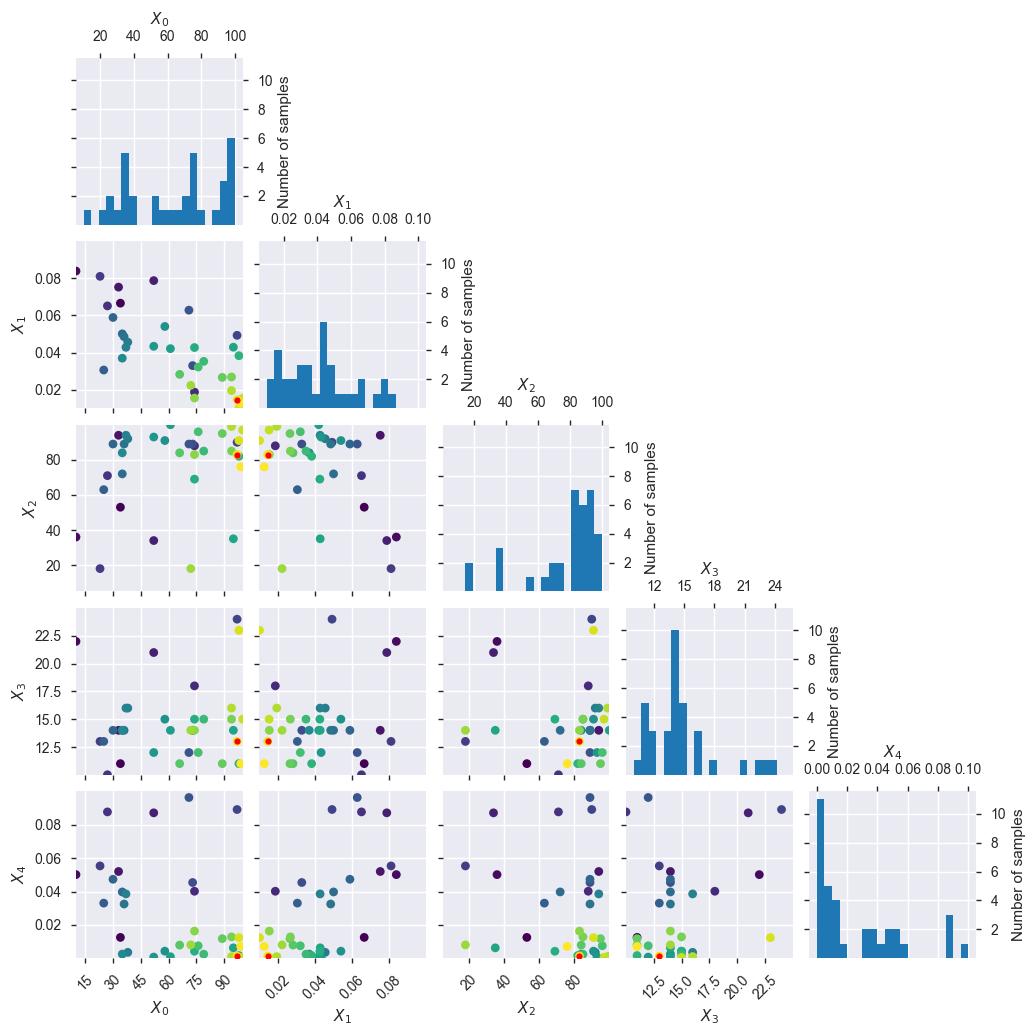

In [155]:
_ = plot_evaluations(res_fm_itemfeat)

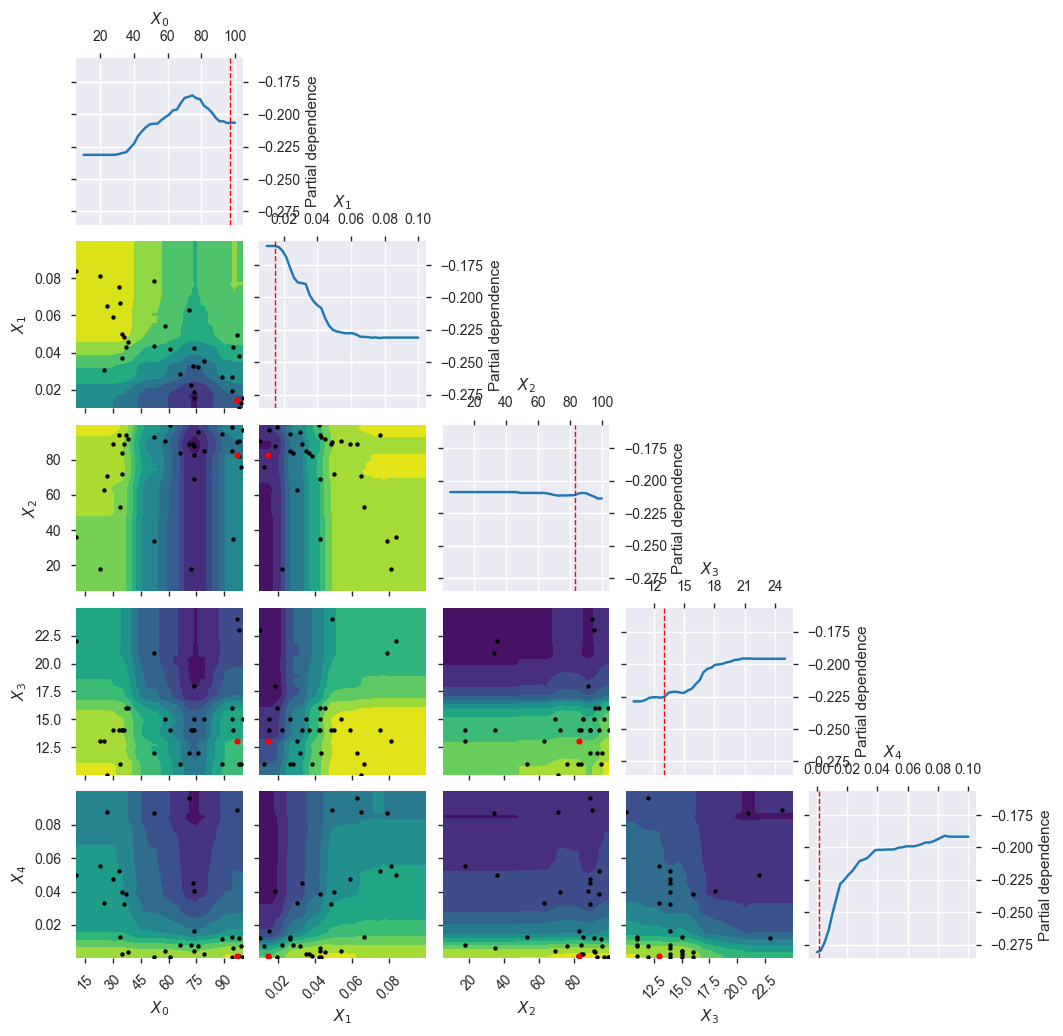

In [156]:
_ = plot_objective(res_fm_itemfeat)

In [157]:
# epochs: 97
# learning_rate: 0.01456160162366714
# no_components: 83
# max_sampled: 13
# user_alpha: 0.0012941797040862961

model = LightFM(loss='warp'
                ,learning_rate=0.015
                ,no_components=83
                ,max_sampled=13
                ,user_alpha=0.0013)

# Construct curves for AUC and P@k for the model incorporating features
EPOCHS = 100
train_item_auc = []
test_item_auc = []
train_item_pak = []
test_item_pak = []


# Let's get an initial pass in to see where we're starting
model.fit_partial(train_mtx, user_features=users_csr, epochs=1)
train_item_auc.append(auc_score(model, train_mtx, user_features=users_csr, num_threads=8).mean())
test_item_auc.append(auc_score(model, test_mtx, user_features=users_csr, num_threads=8).mean())
train_item_pak.append(precision_at_k(model, train_mtx, user_features=users_csr, k=20, num_threads=8).mean())
test_item_pak.append(precision_at_k(model, test_mtx, train_interactions=train_mtx, user_features=users_csr, k=20 \
                              , num_threads=8).mean())
print("Completed epoch: {}".format(1))

# Now train 5 epochs at a time until we reach the max
for i in range(int(EPOCHS/5)):
    model.fit_partial(train_mtx, user_features=users_csr, epochs=5)
    train_item_auc.append(auc_score(model, train_mtx, user_features=users_csr, num_threads=8).mean())
    test_item_auc.append(auc_score(model, test_mtx, train_interactions=train_mtx, user_features=users_csr \
                             , num_threads=8).mean())
    train_item_pak.append(precision_at_k(model, train_mtx, user_features=users_csr, k=20, num_threads=8).mean())
    test_item_pak.append(precision_at_k(model, test_mtx, train_interactions=train_mtx, user_features=users_csr, k=20 \
                                  , num_threads=8).mean())
    print("Completed epoch: {}".format(1+(i+1)*5))


Completed epoch: 1
Completed epoch: 6
Completed epoch: 11
Completed epoch: 16
Completed epoch: 21
Completed epoch: 26
Completed epoch: 31
Completed epoch: 36
Completed epoch: 41
Completed epoch: 46
Completed epoch: 51
Completed epoch: 56
Completed epoch: 61
Completed epoch: 66
Completed epoch: 71
Completed epoch: 76
Completed epoch: 81
Completed epoch: 86
Completed epoch: 91
Completed epoch: 96
Completed epoch: 101


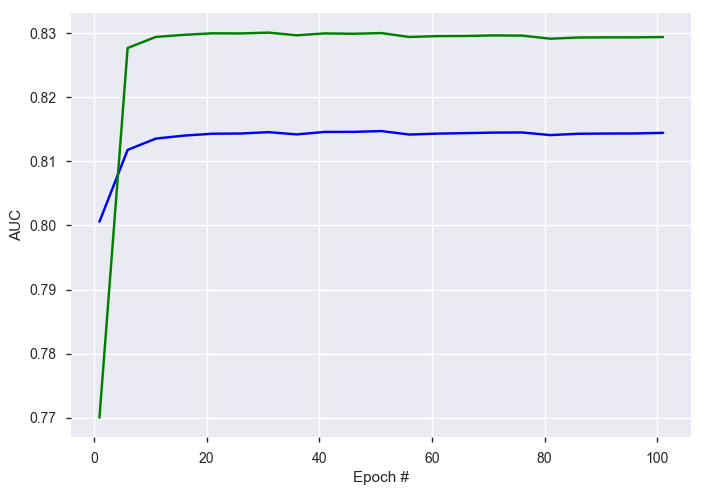

In [161]:
# Plot the AUC for the hybrid model
plt.plot(range(1, EPOCHS+2, 5), train_item_auc, 'b')
plt.plot(range(1, EPOCHS+2, 5), test_item_auc, 'g')
plt.ylabel('AUC')
plt.xlabel('Epoch #')
plt.show()

In [ ]:
# Print the exact AUC numbers for the hybrid model
train_auc = auc_score(model, train_mtx, user_features=users_csr, num_threads=8).mean()
test_auc = auc_score(model, test_mtx, train_interactions=train_mtx, \
                     user_features=users_csr, num_threads=8).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

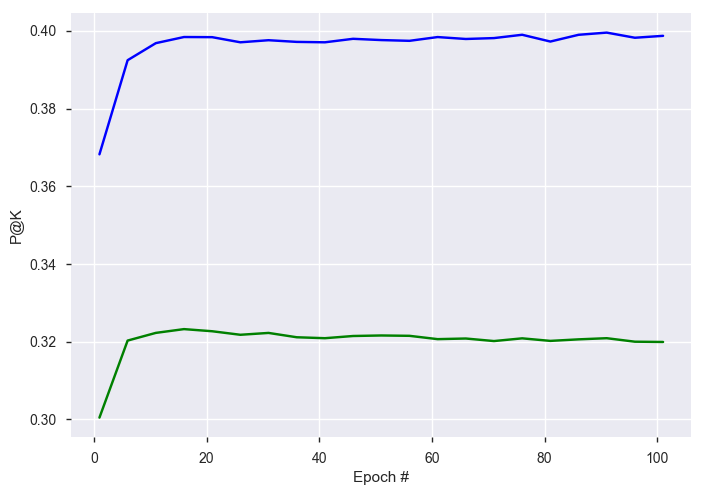

In [163]:
# Plot the P@k for the hybrid model
plt.plot(range(1, EPOCHS+2, 5), train_item_pak, 'b')
plt.plot(range(1, EPOCHS+2, 5), test_item_pak, 'g')
plt.ylabel('P@K')
plt.xlabel('Epoch #')
plt.show()

In [ ]:
# Print the exact P@k numbers for the hybrid model
train_precision = precision_at_k(model, train_mtx, user_features=users_csr, k=20, num_threads=8).mean()
test_precision = precision_at_k(model, test_mtx, train_interactions=train_mtx, \
                                user_features=users_csr, k=20, num_threads=8).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

In [58]:
# Print out the top 5 recommendations for any random 5 users - this is essentially a sanity check (specifically, we
# want to see that each user has different ID's)
for i in random.sample(range(1, 6550), 5):
    print("User idx: {} ---------------------------------------".format(i))
    predictions = model.predict(i, lookup['index'].values, user_features=users_csr, num_threads=8)
    preds_df = pd.DataFrame({'useridx': lookup['index'].values, 'rankscore': predictions})
    print(preds_df.sort_values('rankscore', ascending=False).head())
    rankscore, rankeduser = np.unique(predictions[~np.isnan(predictions)], return_index=True)

User idx: 6277 ---------------------------------------
       rankscore  useridx
1844 -585.119995     1844
5772 -737.319824     5772
5940 -826.285034     5940
5500 -849.601929     5500
2958 -888.083801     2958
User idx: 6548 ---------------------------------------
       rankscore  useridx
1844 -640.044983     1844
5772 -756.640991     5772
5940 -887.613770     5940
5500 -923.261658     5500
2958 -955.397949     2958
User idx: 4875 ---------------------------------------
        rankscore  useridx
5772  2071.391113     5772
1845 -5970.205566     1845
4185 -6557.913574     4185
63   -6821.677246       63
775  -7285.648438      775
User idx: 1048 ---------------------------------------
       rankscore  useridx
1844 -673.610107     1844
5772 -768.448120     5772
5940 -925.092468     5940
5500 -968.275757     5500
2958 -996.534180     2958
User idx: 3847 ---------------------------------------
         rankscore  useridx
5772 -11165.994141     5772
1845 -19616.074219     1845
4185 -19898

In [59]:
for pred in preds_df.useridx.values[:5]:
    print(lookup[lookup['index'] == pred])

   index     id
0      0  54362
   index     id
1      1  73244
   index     id
2      2  76839
   index     id
3      3  92132
   index     id
4      4  92220


In [143]:
from IPython.display import Image
Image(url="https://az521087.vo.msecnd.net/photos/92c6a4d4-581b-4c75-bd17-368976a5d144.jpg")

In [142]:
Image(url="https://az521087.vo.msecnd.net/photos/3adfdfb1-b1c8-41d2-84e3-dda061079331.jpg")

In [146]:
Image(url="https://az521087.vo.msecnd.net/photos/2c85007e-26c7-4379-9e74-fc0eabbb66a4.jpg")